# LPT-R Thresholding with iNat Models

This notebook applies LPT-R binarization to species range predictions from a SINR-trained iNat geo model. It reproduces and verifies the approach from Dorm et al. (2024), compares to fixed-threshold alternatives, and evaluates performance using precision, recall, and F1 against expert ranges.

Taxon ID used: 13270 (Wood Thrush)

Model: tf_geoprior_2_20_r6_elevation.h5  
Elevation raster: elev_scaled.npy  
Taxonomy: vision-export-20250119070012-aka-2.20  
Range source: IUCN H3 mask csvs

In [1]:
import os
from pathlib import Path
import sys

import h3
import h3pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydeck as pdk
from shapely.geometry import shape
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tqdm.auto import tqdm

2025-04-21 15:56:26.458914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-21 15:56:26.458943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-21 15:56:26.460080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-21 15:56:26.465408: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-21 15:56:26.998268: W tensorflow/compiler/tf2

In [2]:
sys.path.append('..')

In [3]:
from lib.models.tf_gp_model import TFGeoPriorModel
from lib.models.encoders import CoordEncoder

In [4]:
GEOMODEL_PATH = "/home/alex/export_eval_models/model_exports/tf_geoprior_2_20_r6_elevation.h5"
ELEVATION_RASTER_PATH = "/home/alex/sinr/data/env/elev_scaled.npy"
INPUT_ENCODING = "sinusoidal"
TAX_2_20_FILE = "/data-ssd/alex/datasets/vision-export-20250119070012-aka-2.20/taxonomy.csv"
TAXON_RANGE_CSVS_DIR = "/data-ssd/alex/datasets/vision-export-20250216070017-aka-2.21/taxon_range_csvs/"
TARGET_TAXON_ID = 13270
SPATIAL_DATA_2_20_FILE = "/data-ssd/alex/datasets/vision-export-20250119070012-aka-2.20/spatial_data.parquet"
SPATIAL_DATA_2_20_H3_FILE = "/data-ssd/alex/datasets/vision-export-20250119070012-aka-2.20/spatial_data_h3.parquet"

## 1. Load model and setup

In [5]:
model = TFGeoPriorModel(GEOMODEL_PATH)
raster = np.load(ELEVATION_RASTER_PATH).astype(np.float32)
encoder = CoordEncoder(INPUT_ENCODING, raster=raster)
tax_2_20 = pd.read_csv(TAX_2_20_FILE)

2025-04-21 15:56:27.476341: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-21 15:56:27.508469: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-21 15:56:27.508687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
def coord_grid(grid_size):
    feats = np.zeros(
        (grid_size[0], grid_size[1], 2),
        dtype=np.float32
    )
    mg = np.meshgrid(
        np.linspace(-180, 180, feats.shape[1]),
        np.linspace(90, -90, feats.shape[0]),
    )
    feats[:, :, 0] = mg[0]
    feats[:, :, 1] = mg[1]
    
    return feats.reshape(feats.shape[0] * feats.shape[1], 2)

## 2. Load and visualize expert range

In [7]:
known_range = pd.read_csv(
    Path(TAXON_RANGE_CSVS_DIR) / f"{TARGET_TAXON_ID}.csv",
    names=["h3_04"],
)

In [8]:
layer = pdk.Layer(
    "H3HexagonLayer",
    known_range,
    pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    get_hexagon="h3_04",
    get_fill_color="[0, 255, 255]",
    get_line_color="[0, 255, 255]",
    line_width_min_pixels=2,
)
view_state = pdk.ViewState(
    latitude=37.7749295, 
    longitude=-90.4194155, 
    zoom=2, 
    bearing=0, 
    pitch=0
)
r = pdk.Deck(
    layers=[layer], 
    initial_view_state=view_state, 
    tooltip={"text": "Score: {preds}"}
)
r.show()

## 3. Load and visualize training data

In [9]:
spatial_train = pd.read_parquet(SPATIAL_DATA_2_20_FILE)

In [10]:
spatial_train_13270 = spatial_train[(spatial_train.taxon_id==TARGET_TAXON_ID)&(spatial_train.community==1)]

In [11]:
spatial_train_13270_h3 = spatial_train_13270.h3.geo_to_h3(
    resolution=4,
    lat_col="latitude",
    lng_col="longitude"
)
spatial_train_13270_h3.reset_index(inplace=True)

In [12]:
layer = pdk.Layer(
    "H3HexagonLayer",
    spatial_train_13270_h3[["h3_04"]],
    pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    get_hexagon="h3_04",
    get_fill_color="[0, 255, 255]",
    get_line_color="[0, 255, 255]",
    line_width_min_pixels=2,
)
view_state = pdk.ViewState(
    latitude=37.7749295, 
    longitude=-90.4194155, 
    zoom=2, 
    bearing=0, 
    pitch=0
)
r = pdk.Deck(
    layers=[layer], 
    initial_view_state=view_state, 
)
r.show()

## 4. Predict and visualize with fixed threshold

In [13]:
res0_cells = h3.get_res0_indexes()
all_cells = set()
for res0 in tqdm(res0_cells):
    children = h3.h3_to_children(res0, 4)
    all_cells.update(children)
    
cells_df = pd.DataFrame({"h3_04": list(all_cells)})
cells_df.set_index("h3_04", inplace=True)

  0%|          | 0/122 [00:00<?, ?it/s]

In [14]:
dfh3 = cells_df.h3.h3_to_geo()
dfh3["lng"] = dfh3.geometry.x
dfh3["lat"] = dfh3.geometry.y
_ = dfh3.pop("geometry")

In [15]:
target_class_id = int(tax_2_20[tax_2_20.taxon_id==TARGET_TAXON_ID].iloc[0].leaf_class_id)

In [16]:
locs = dfh3[["lng", "lat"]].values
encoded_locs = encoder.encode(locs)
geo_model_features = model.get_loc_emb(encoded_locs)
preds = model.eval_one_class_from_feats(
    geo_model_features,
    class_of_interest=target_class_id
)
dfh3["preds"] = preds[0]
dfh3.reset_index(inplace=True)

In [44]:
layer = pdk.Layer(
    "H3HexagonLayer",
    dfh3[dfh3.preds>0.001],
    pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    get_hexagon="h3_04",
    get_fill_color="[0, 255, 255]",
    get_line_color="[0, 255, 255]",
    line_width_min_pixels=2,
)
view_state = pdk.ViewState(
    latitude=37.7749295, 
    longitude=-90.4194155, 
    zoom=2, 
    bearing=0, 
    pitch=0
)
r = pdk.Deck(
    layers=[layer], 
    initial_view_state=view_state, 
)
r.show()

## 5. Calculate LPT-R threshold

In [18]:
spatial_train_13270_h3 = spatial_train_13270.h3.geo_to_h3(
    resolution=4,
    lat_col="latitude",
    lng_col="longitude"
)
spatial_train_13270_h3.reset_index(inplace=True)
presence_preds = dfh3[dfh3['h3_04'].isin(spatial_train_13270_h3['h3_04'])]
lpt_r_threshold = np.percentile(presence_preds.preds, 5)
print(f"calculated LPT-R threshold is {lpt_r_threshold}")

calculated LPT-R threshold is 0.0023804576485417783


## 6. Compare Dorm et al. technique

In [19]:
# this will take a minute with a large spatial train file
spatial_train_h3 = spatial_train.h3.geo_to_h3(
    resolution=4,
    lat_col="latitude",
    lng_col="longitude"
)

In [20]:
# make presence absence dataframe
all_spatial_grid_counts = spatial_train_h3.index.value_counts()
presence_absence = pd.DataFrame({
    "background": all_spatial_grid_counts,
})
presence_absence = presence_absence.fillna(0)
target_spatial_grid_counts = spatial_train_h3[spatial_train_h3.taxon_id==TARGET_TAXON_ID].index.value_counts()  
presence_absence["forground"] = target_spatial_grid_counts
presence_absence["predictions"] = dfh3.set_index("h3_04")["preds"]
presence_absence.forground = presence_absence.forground.fillna(0)
presences = presence_absence[(presence_absence["forground"]>0)]["predictions"]
lpt_r_thresh_paper_technique = np.percentile(presences, 5)

In [21]:
lpt_r_threshold == lpt_r_thresh_paper_technique

False

## 7. Visualize LPT-R thresholded range

In [22]:
dfh3['binary_lpt_r'] = (dfh3['preds'] >= lpt_r_threshold).astype(int)
dfh3_clipped_lpt_r_5 = dfh3[dfh3.binary_lpt_r==1]

In [23]:
layer = pdk.Layer(
    "H3HexagonLayer",
    dfh3_clipped_lpt_r_5,
    pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    get_hexagon="h3_04",
    get_fill_color="[0, 255, 255]",
    get_line_color="[0, 255, 255]",
    line_width_min_pixels=2,
)

view_state = pdk.ViewState(
    latitude=37.7749295, 
    longitude=-90.4194155, 
    zoom=2, 
    bearing=0, 
    pitch=0
)
r = pdk.Deck(
    layers=[layer], 
    initial_view_state=view_state, 
    tooltip={"text": "Score: {preds}"}
)
r.show()

## 8. sanity check, histogram of scores with thresholds 

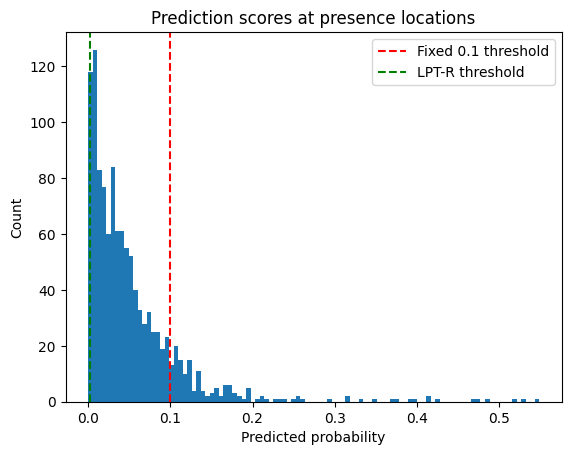

In [24]:
plt.hist(presence_preds.preds, bins=100)
plt.axvline(0.1, color='red', linestyle='--', label='Fixed 0.1 threshold')
plt.axvline(lpt_r_threshold, color='green', linestyle='--', label='LPT-R threshold')
plt.title("Prediction scores at presence locations")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.legend()
plt.show()

## 9. Precision, recall, and F1 calculation


In [25]:
all_cells = dfh3["h3_04"]

In [26]:
predicted_cells = set(dfh3[dfh3['binary_lpt_r'] == 1]['h3_04'])
y_pred = [1 if cell in predicted_cells else 0 for cell in all_cells]

In [27]:
true_cells = set(known_range["h3_04"])
y_true = [1 if cell in true_cells else 0 for cell in all_cells]

In [28]:
precision = precision_score(y_true, y_pred)
precision

0.7346502936465563

In [29]:
recall = recall_score(y_true, y_pred)
recall

0.8501699104108743

In [30]:
f1 = f1_score(y_true, y_pred)
f1

0.7881999140770443

## 10. Compare vs older threshold


In [31]:
old_method_threshold = 0.0029526805

In [32]:
lpt_r_threshold, old_method_threshold

(0.0023804576485417783, 0.0029526805)

In [33]:
predicted_cells = set(dfh3[dfh3['preds'] > old_method_threshold]['h3_04'])
y_pred = [1 if cell in predicted_cells else 0 for cell in all_cells]

In [34]:
precision = precision_score(y_true, y_pred)
precision

0.8144673123486683

In [35]:
recall = recall_score(y_true, y_pred)
recall

0.8313253012048193

In [36]:
f1 = f1_score(y_true, y_pred)
f1

0.8228099678948173

## 11. Redo the f1 calculation in a loop all at once

In [37]:
taxon_ids = [
    13270
]
taxon_range_csvs = Path(TAXON_RANGE_CSVS_DIR)
f1s = []

In [38]:
for i in range(len(taxon_ids)):
    taxon_id = taxon_ids[i]
    class_of_interest = int(tax_2_20[tax_2_20.taxon_id==taxon_id].iloc[0].leaf_class_id)
    
    preds = model.eval_one_class_from_feats(
        geo_model_features,
        class_of_interest=class_of_interest
    )
    dfh3["preds"] = preds[0]
    
    spatial_train_class = spatial_train[(spatial_train.taxon_id==taxon_id)]
    spatial_train_class_h3 = spatial_train_class.h3.geo_to_h3(
        resolution=4,
        lat_col="latitude",
        lng_col="longitude"
    )
    spatial_train_class_h3.reset_index(inplace=True)

    presence_preds = dfh3[dfh3['h3_04'].isin(spatial_train_class_h3['h3_04'])]
    lpt_r_threshold = np.percentile(presence_preds.preds, 5)

    range_file = taxon_range_csvs / f"{taxon_id}.csv"
    if os.path.exists(range_file):
        known_range = pd.read_csv(range_file, names=["h3_04"])
        dfh3['binary_lpt_r'] = (dfh3['preds'] >= lpt_r_threshold).astype(int)
        
        all_cells = dfh3["h3_04"]
        predicted_cells = set(dfh3[dfh3['binary_lpt_r'] == 1]['h3_04'])        
        y_pred = [1 if cell in predicted_cells else 0 for cell in all_cells]
        true_cells = known_range.values
        y_true = [1 if cell in true_cells else 0 for cell in all_cells]
        
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        f1s.append(f1)
    else:
        pass
        
np.array(f1s).mean()

0.7871945119336858

## 12. Show expert range as an outline

In [39]:
known_range = pd.read_csv(
    "/data-ssd/alex/datasets/vision-export-20250216070017-aka-2.21/taxon_range_csvs/13270.csv",
    names=["asdf"],
)

known_range_geojson_polys = h3.h3_set_to_multi_polygon(known_range.asdf.values, geo_json=True)

In [40]:
expert_range_features = []

for poly in tqdm(known_range_geojson_polys):
    outer = poly[0]
    holes = poly[1:] if len(poly) > 1 else []
    coords = [outer] + holes  # GeoJSON format
    expert_range_features.append({
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": coords
        },
        "properties": {"name": "Expert Range"}
    })

expert_range_features = {
    "type": "FeatureCollection",
    "features": expert_range_features
}

  0%|          | 0/5 [00:00<?, ?it/s]

In [41]:
geojson_known_range_layer = pdk.Layer(
    "GeoJsonLayer",
    data=expert_range_features,
    stroked=True,
    filled=False,
    get_line_color=[255, 255, 255],
    line_width_min_pixels=1,
    pickable=True,
)
view_state = pdk.ViewState(
    latitude=37.5,
    longitude=-90,
    zoom=2,
    bearing=0,
    pitch=0,
)
r = pdk.Deck(
    layers=[geojson_known_range_layer],
    initial_view_state=view_state,
)
r.show()

## 13. Visual overlays of expert vs predicted

In [42]:
geojson_polys_predicted = h3.h3_set_to_multi_polygon(predicted_cells, geo_json=True)
predicted_feats = []

for poly in tqdm(geojson_polys_predicted):
    outer = poly[0]
    holes = poly[1:] if len(poly) > 1 else []
    coords = [outer] + holes  # GeoJSON format
    predicted_feats.append({
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": coords
        },
        "properties": {"name": "Predicted Range"}
    })

geojson_predicted = {
    "type": "FeatureCollection",
    "features": predicted_feats
}

geojson_predicted_range_layer = pdk.Layer(
    "GeoJsonLayer",
    data=geojson_predicted,
    stroked=False,
    filled=True,
    get_fill_color=[0, 200, 100, 120],  # green-ish
    get_line_color=[0, 0, 0],
    line_width_min_pixels=1,
    pickable=True,
)


  0%|          | 0/41 [00:00<?, ?it/s]

In [43]:
view_state = pdk.ViewState(
    latitude=37.5,
    longitude=-90,
    zoom=2,
    bearing=0,
    pitch=0,
)
r = pdk.Deck(
    layers=[geojson_predicted_range_layer, geojson_known_range_layer],
    initial_view_state=view_state,
)
r.show()